# How much influence does the early stage of a League of legends match have on its result?
![Image](https://s3-sa-east-1.amazonaws.com/siterawar-wp-uploads/wp-content/uploads/2018/06/18094449/LOL.jpg)

**League of Legends** is a multiplayer online battle arena (MOBA) game made by Riot Games.  In each match, teams work together to achieve a victory condition, typically destroying the core building (called the **Nexus**) in the enemy team's base after bypassing a line of defensive structures called **turrets**, or **towers**. Also, it's **impossible** for a match to end in a tie since it only ends when one Nexus is destroyed.

Now that you're already introduced to the basics of the game, here are a few more things to notice:
*   Each match has 5 players in each team.
*   Matches last anywhere from 20 to 50 minutes.
*   Players control characters called champions, chosen or assigned every match.
*   Champions begin every match at level 1, and then gain experience over the course of the match to achieve a maximum level of 18.
*   *Ward* is the name given to a sentinel, an item that can provide vision of the enemy team, thus giving information about a certain area.
*   Teams are usually referred to by blue, or red(depending on side of the arena).
*   The game has a system of ranks, in which the diamond rank is one of the highests(only 2% top players reach it).
<br>

First, I want to clarify three time-concepts that we'll need during this analysis:<br><br>
<u>*Early game*</u>: It's the term used to refer to the first 10 minutes of each match<br>
<u>*Mid game*</u>: It's the term used to refer to the interval between 10-25 minutes of a match.<br>
<u>*Late game*</u>: It's the term used to refer from 25 minutes within the match, till the end.<br><br>
Of course, those definitions are all approximations, as the composition of champions and the skill gap between teams can heavily influence the lenght of each stage.

The dataset contains information from around 10.000 diamond rank matches, and the data was extracted when each game had a duration of 10 minutes(at the end of early game).

---

If you're looking for a more detailed description of the dataset, check out it's link:<br>https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

---
Having all said, let's import the modules we'll use and take a look at the dataset




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import plot_tree as plot_xgboost

Importing the dataset and visualizing it with **pandas**



In [2]:
filepath = '../input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv'
df = pd.read_csv(filepath)
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


## Goal of the study

The goal is to develop a machine learning model to predict which team is going to win. The variable that represents the outcome of a match is *blueWins*, meaning:
* 1 - Blue team wins.
* 0 - Blue team loses(therefore, red team wins).

Now, let's look deeper into the dataset

## Exploratory data analysis (EDA)

Let's have a look at the shape of our dataset

In [3]:
rows, columns = df.shape
print(f'Rows: {rows}, columns: {columns}')

Rows: 9879, columns: 40


Are there any missing values in our dataset?

In [4]:
nan_column_count = 0
for column in df.isna().sum():
    if column>0:
        print(column)
        nan_column_count+=1
if nan_column_count == 0:
    print('No missing values in your dataset!')

No missing values in your dataset!


Now, a closer look to the data types

In [5]:
df.dtypes

gameId                            int64
blueWins                          int64
blueWardsPlaced                   int64
blueWardsDestroyed                int64
blueFirstBlood                    int64
blueKills                         int64
blueDeaths                        int64
blueAssists                       int64
blueEliteMonsters                 int64
blueDragons                       int64
blueHeralds                       int64
blueTowersDestroyed               int64
blueTotalGold                     int64
blueAvgLevel                    float64
blueTotalExperience               int64
blueTotalMinionsKilled            int64
blueTotalJungleMinionsKilled      int64
blueGoldDiff                      int64
blueExperienceDiff                int64
blueCSPerMin                    float64
blueGoldPerMin                  float64
redWardsPlaced                    int64
redWardsDestroyed                 int64
redFirstBlood                     int64
redKills                          int64


Since every column is a integer or a float, there is no worrying about transforming categorical data.

**Is our dataset evenly distributed?** If not, we might have some issues regarding bias on our dataset, producing a fake accuracy measure.

0    4949
1    4930
Name: blueWins, dtype: int64


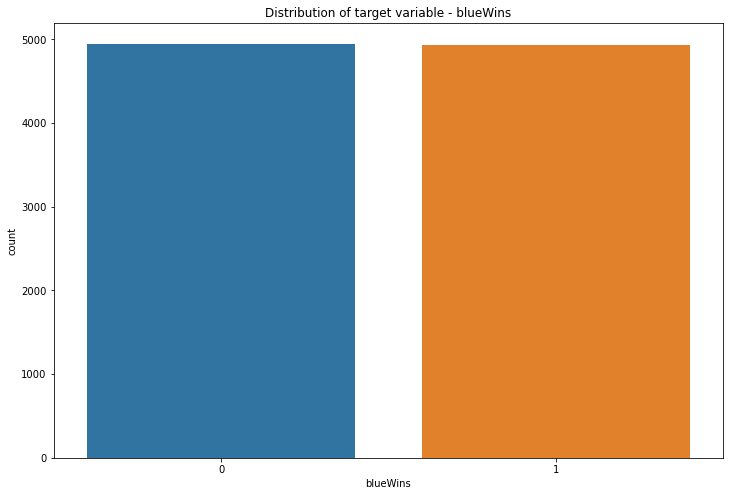

In [6]:
plt.figure(figsize=(12,8))
plt.title('Distribution of target variable - blueWins')
plt.ylabel('Amount of wins')
sns.countplot(df['blueWins'])
print(df['blueWins'].value_counts())

It seems that the data is evenly distributed.

## Cleaning up the data


The first variable we must pay attention to is *gameId*. It stands for a unique Id for each match, meaning it's only a way to identify individual matches

In [7]:
len(df['gameId'].unique())

9879

The lenght of unique gameIds is the same as the amount of rows in the dataset. That means that there is no duplicates, and each row represents an unique match.<br>

---
Since *gameId* doesn't add any informational value, we'll exclude it from our analysis.



In [8]:
#Dropping 'gameId' variable
columns_to_drop = ['gameId']
df = df.drop('gameId', axis=1)

### Splitting the dataset

Define our target variable

In [9]:
y = df['blueWins']

Define which columns will be used as features of our model(every column except *blueWins*)

In [10]:
X = df.drop('blueWins', axis=1)

Splitting the datasets in two

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)  

## Decision tree classifier with no feature engineering

First, let's define a function to train any model and return its accuracy:

In [12]:
def test_classifier(model, X_train, X_test, y_train, y_test):      
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return f'{round(accuracy,4)*100}%'

Now, build a decision tree classifier model.

We'll be setting the random state seed as = 1, in order to have a reproducible and reliable model.

The accuracy of your model is: 64.21%


Text(0.5, 1.0, 'Confusion matrix')

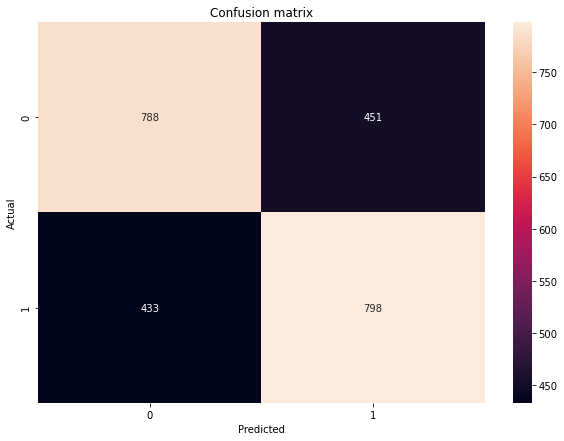

In [13]:
tree_model = DecisionTreeClassifier(random_state=1)

first_run = test_classifier(tree_model, X_train, X_test, y_train, y_test)
print(f'The accuracy of your model is: {first_run}')
tree_model.fit(X_train, y_train)
predictions = tree_model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,7))
plt.ylabel('actual')
plt.xlabel('predicted')
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion matrix')
 #MELHORAR O PLOT DA CONFUSION MATRIX
    

64% of accuracy is pretty low, even though we don't have much data on each match.

---
Let's try and tweak our model a little, to see how much more accuracy we can extract from it

In [14]:
for x in range(2,21,2):
    tree_model = DecisionTreeClassifier(max_leaf_nodes= x,random_state=1)
    test_model = test_classifier(tree_model, X_train, X_test, y_train, y_test)
    print(f'max leaf nodes: {x}- accuracy: {test_model}')

max leaf nodes: 2- accuracy: 73.28%
max leaf nodes: 4- accuracy: 73.28%
max leaf nodes: 6- accuracy: 73.28%
max leaf nodes: 8- accuracy: 72.11%
max leaf nodes: 10- accuracy: 72.11%
max leaf nodes: 12- accuracy: 72.59%
max leaf nodes: 14- accuracy: 72.47%
max leaf nodes: 16- accuracy: 72.47%
max leaf nodes: 18- accuracy: 71.98%
max leaf nodes: 20- accuracy: 71.98%


Tweaking *max_leaf_nodes* gave us an 9% increase in accuracy. We're sticking with (2,4,6) for this variable, since these values didn't lower our accuracy.
<br><br>
Now let's try tweaking a few more variables...

In [15]:
for depth in range(1,5):    
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    test_model = test_classifier(tree_model, X_train, X_test, y_train, y_test)
    print(f'max_depth: {depth} - accuracy: {test_model}')

max_depth: 1 - accuracy: 73.28%
max_depth: 2 - accuracy: 73.28%
max_depth: 3 - accuracy: 73.28%
max_depth: 4 - accuracy: 72.55%


Since tweaking *max_depth* 1-3 led to no change, we'll leave it as 3, and *max_leaf_nodes* as None(It doesn't change our accuracy and will give better visualization results below.<br>

---
Now, let's plot the tree for our final model to get a better understanding of the best modeling process.

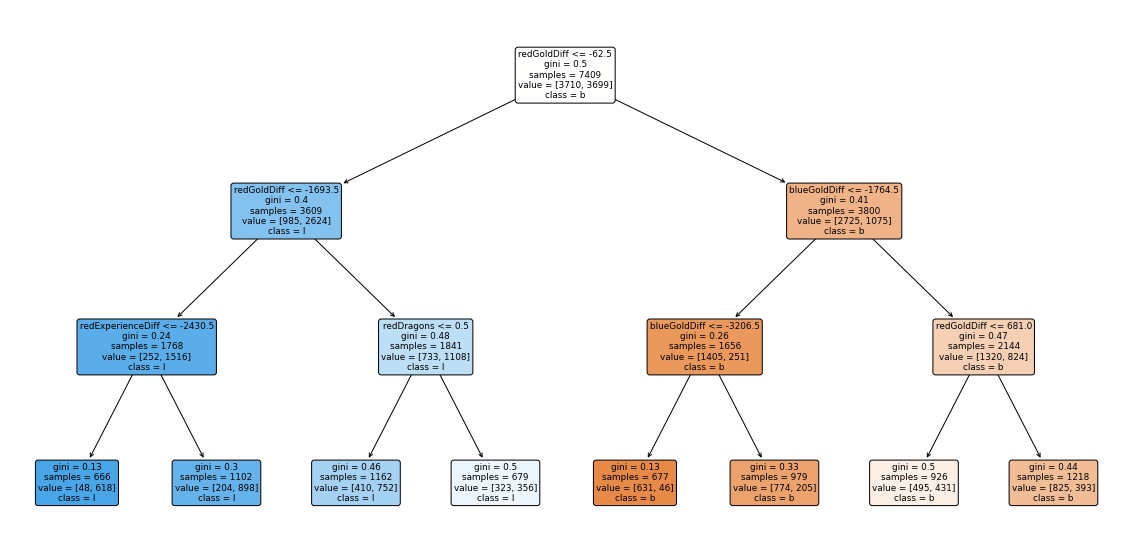

In [16]:
final_tree_model = DecisionTreeClassifier(max_depth = 3, random_state=1)
final_tree_model.fit(X_train, y_train)
predictions = final_tree_model.predict(X_test)
plt.figure(figsize=(20,10))
_ = plot_tree(final_tree_model, feature_names = X_train.columns, class_names = 'blueWins',
                rounded = True, proportion = False, precision = 2, filled = True)

And, of course, the confusion matrix for this model

Text(0.5, 1.0, 'Confusion matrix')

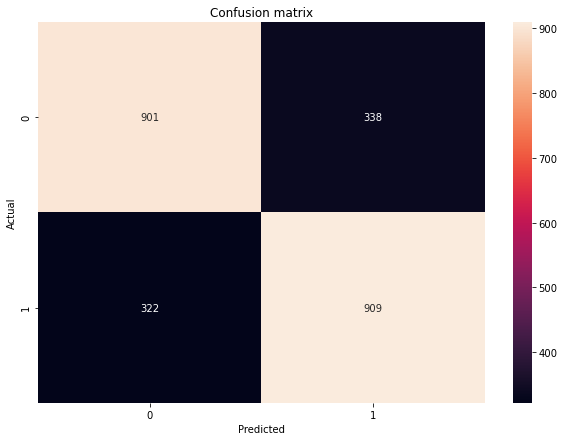

In [17]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,7))
plt.ylabel('actual')
plt.xlabel('predicted')
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion matrix')

## Feature engineering

As evaluated, there is just too many variables in this dataset. But in reality, most of them are representations of the same variable, just for opposite teams.<br>
So, for the sake of simplifying the correlation for our model, we'll be making some feature engineering, in which most of it will be based on:

**Diff**Variable = **blue**Variable - **red**Variable

That way we create relationships between variables, expecting our results to improve.

In [18]:
diff_variables = ['WardsPlaced', 'WardsDestroyed','TotalMinionsKilled', 'Kills', 'Deaths', 'Assists', 'EliteMonsters', 'Dragons', 'Heralds', 'TowersDestroyed', 'AvgLevel']
variables_to_drop_red = ['GoldDiff', 'ExperienceDiff']
X_with_fe = pd.DataFrame()
X_with_fe['FirstBlood'] = X['blueFirstBlood']
for var in diff_variables:
    X_with_fe[f'Dif{var}'] = X[f'blue{var}'] - X[f'red{var}']

for var in variables_to_drop_red:
    X_with_fe[var] = X[f'blue{var}']
X_with_fe.head()

,FirstBlood,DifWardsPlaced,DifWardsDestroyed,DifTotalMinionsKilled,DifKills,DifDeaths,DifAssists,DifEliteMonsters,DifDragons,DifHeralds,DifTowersDestroyed,DifAvgLevel,GoldDiff,ExperienceDiff
0,1,13,-4,-2,3,-3,3,0,0,0,0,-0.2,643,-8
1,0,0,0,-66,0,0,3,-2,-1,-1,-1,-0.2,-2908,-1173
2,0,0,-3,-17,-4,4,-10,1,1,0,0,-0.4,-1172,-1033
3,0,28,-1,-34,-1,1,-5,1,0,1,0,0.0,-1321,-7
4,0,58,2,-15,0,0,-1,-1,-1,0,0,0.0,-1004,230


Now, let's split our dataset again

In [19]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_with_fe, y, random_state=1)

Test on our decision tree classifier

In [20]:
tree_model = DecisionTreeClassifier(max_leaf_nodes=2, random_state=1)
test_model = test_classifier(tree_model, X_train_fe, X_test_fe, y_train_fe, y_test_fe)
print(f'accuracy: {test_model}')

accuracy: 73.28%


Surprisingly, getting rid of junk variables and creating new features had no effect on our accuracy score. That could mean decision tree classifier is simply a limited model choice for this dataset. Let's take a look and see if it's confusion matrix had any change

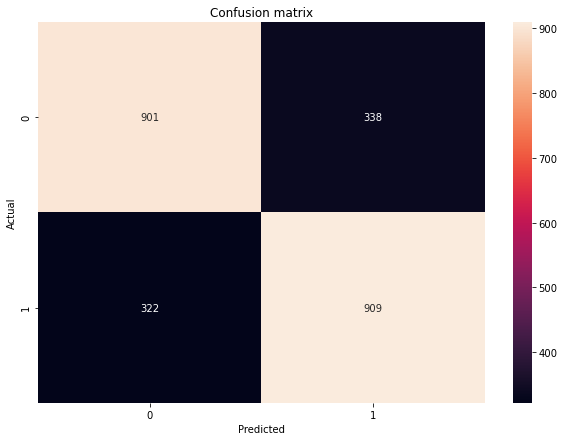

In [21]:
tree_model.fit(X_train_fe, y_train_fe)
predictions = tree_model.predict(X_test_fe)
cm = confusion_matrix(y_test_fe, predictions)
plt.figure(figsize=(10,7))
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
_ = ax.set_title('Confusion matrix')

Also, no change on false negatives and false positives.

## Moving on to random forest classifier

Here, we pack both datasets as tuples, so it is easy to run a for loop on both and avoid writing repetitive code.

In [22]:
dataset_1 = (X_train, X_test, y_train, y_test, 'dataset_1') #Tuple of the unmodified dataset
dataset_2 = (X_train_fe, X_test_fe, y_train_fe, y_test_fe, 'dataset_2') #Tuple of the dataset with feature engineering

Define the function to handle datasets as tuples

In [23]:
def test_classifier_2(model, dataset):
    model.fit(dataset[0], dataset[2])
    predictions = model.predict(dataset[1])
    accuracy = accuracy_score(dataset[3], predictions)
    return f'{round(accuracy,4)*100}%'

Iterate over the model to tune the *n_estimators* parameter

In [24]:
for est in range(25, 101, 25):
    for dataset in (dataset_1, dataset_2):
        rf_model = RandomForestClassifier(n_estimators = est, random_state=1)
        print(f'{dataset[4]} - n_estimators:{est} -  Your accuracy is: {test_classifier_2(rf_model, dataset)}')

dataset_1 - n_estimators:25 -  Your accuracy is: 70.89%
dataset_2 - n_estimators:25 -  Your accuracy is: 70.93%
dataset_1 - n_estimators:50 -  Your accuracy is: 72.35000000000001%
dataset_2 - n_estimators:50 -  Your accuracy is: 71.41999999999999%
dataset_1 - n_estimators:75 -  Your accuracy is: 72.63%
dataset_2 - n_estimators:75 -  Your accuracy is: 71.89999999999999%
dataset_1 - n_estimators:100 -  Your accuracy is: 72.75%
dataset_2 - n_estimators:100 -  Your accuracy is: 72.06%


Surprisingly, the first dataset, with no feature engineering, generally got better results than the second dataset.
<br>
Now, let's tweak *max_depth* variable, within a range of 2 and 10, leaving n_estimators as the default=100

In [25]:
for depth in range(2,11,2):
    for dataset in (dataset_1, dataset_2):
        rf_model = RandomForestClassifier(max_depth=depth,n_estimators = 100, random_state=1)
        print(f'max_estimators: {est} - depth:{depth} -{dataset[4]} - Your accuracy is: {test_classifier_2(rf_model, dataset)}')

max_estimators: 100 - depth:2 -dataset_1 - Your accuracy is: 73.77%
max_estimators: 100 - depth:2 -dataset_2 - Your accuracy is: 74.05000000000001%
max_estimators: 100 - depth:4 -dataset_1 - Your accuracy is: 73.89%
max_estimators: 100 - depth:4 -dataset_2 - Your accuracy is: 73.81%
max_estimators: 100 - depth:6 -dataset_1 - Your accuracy is: 74.33%
max_estimators: 100 - depth:6 -dataset_2 - Your accuracy is: 73.56%
max_estimators: 100 - depth:8 -dataset_1 - Your accuracy is: 73.81%
max_estimators: 100 - depth:8 -dataset_2 - Your accuracy is: 73.52%
max_estimators: 100 - depth:10 -dataset_1 - Your accuracy is: 73.32%
max_estimators: 100 - depth:10 -dataset_2 - Your accuracy is: 72.75%


So far, our highest accuracy score has been of **74.33%**, with n_estimators=100 and max_depth=6. Also, another interesting thing to point out is that, in fact, the feature engineering didn't improve our rfc model. The only reason I can think of, is that it oversimplifies a dataset that already is too limited. I'll talk more about it at the end of the analysis.<br>
So, just for the record, let's plot the best performing rfc model, using the unmodified dataset:

In [26]:
final_rf_model = RandomForestClassifier(max_depth=6,n_estimators = 100, random_state=1)

print(f'Your final accuracy is: {test_classifier_2(final_rf_model, dataset_1)}')

Your final accuracy is: 74.33%


A plot of comparison between models so far:

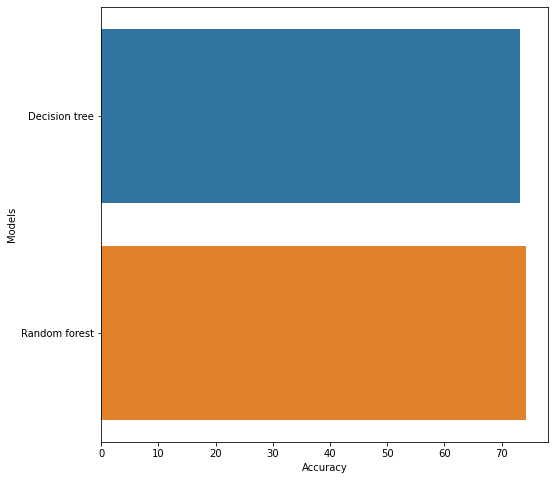

In [27]:
plt.figure(figsize=(8,8))
plot_df = pd.DataFrame({'Models':['Decision tree', 'Random forest'], 'Accuracy':[73.28,74.33]})
ax = sns.barplot(x='Accuracy', y='Models', data=plot_df)

So, **random forest** performed slightly better than **decision tree**.

### A quick run on different algorithms

In [28]:
model_dict ={'Support Vector Classification': SVC(random_state=1),'Gaussian Naive Bayes':GaussianNB(), 'Gradient Boosting Classifier':GradientBoostingClassifier(random_state=1), 'XGBoost': XGBClassifier()}
for model in model_dict:
    print(f'model:{model} - accuracy: {test_classifier_2(model_dict[model], dataset_1)}')

model:Support Vector Classification - accuracy: 73.68%
model:Gaussian Naive Bayes - accuracy: 74.33%
model:Gradient Boosting Classifier - accuracy: 74.49%
model:XGBoost - accuracy: 71.26%


Even with default parameters, Gradient boosting classifier has given us the highest accuracy so far.<br>
Now, let's tune XGBoost a little, since it's an enhanced GB model that tends to give better results.

### XGBClassifier tuning

In [29]:
def xboost_func(model, dataset):

    model.fit(dataset[0], dataset[2], 
             early_stopping_rounds=50, 
             eval_set=[(dataset[1], dataset[3])], 
             verbose=False)
    predictions = model.predict(dataset[1])
    accuracy = accuracy_score(dataset[3], predictions)
    return f'{round(accuracy,4)*100}%'


XGBoost = XGBClassifier(n_estimators=1000, learning_rate=0.06, max_depth= 3, subsample= 0.9, colsample_bytree= 1, gamma= 1)
for df in (dataset_1, dataset_2):  
    test_model = xboost_func(XGBoost,df)
    print(f'XGBoost accuracy on {df[4]}: {test_model}')

XGBoost accuracy on dataset_1: 74.74%
XGBoost accuracy on dataset_2: 74.86%


Our tuned XGBoost model has an accuracy of almost 75%! and this time, the dataset that had feature engineering performed slightly better.<br><br>

### Visualizing the XGBoost model

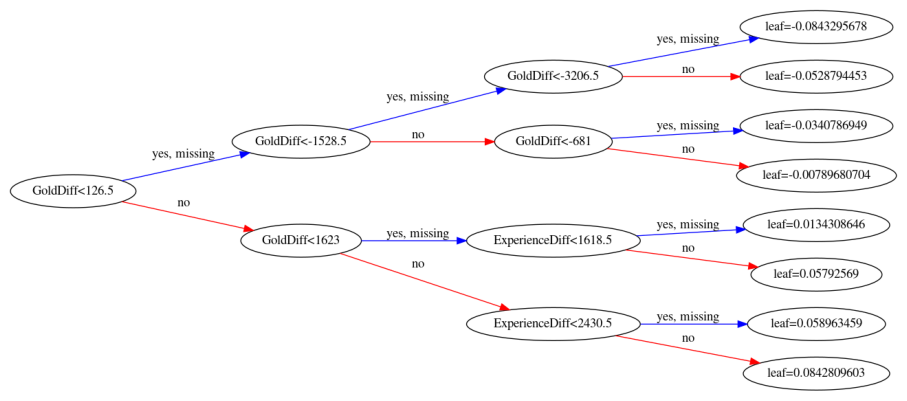

In [30]:
XGBoost.fit(dataset[0], dataset[2], 
             early_stopping_rounds=50, 
             eval_set=[(dataset[1], dataset[3])], 
             verbose=False)
predictions = XGBoost.predict(dataset[1])
fig, ax = plt.subplots()
fig.set_size_inches(16,18)
_ = plot_xgboost(XGBoost, num_trees=4, ax=ax, rankdir='LR')

**Confusion matrix for XGBoost Classifier**

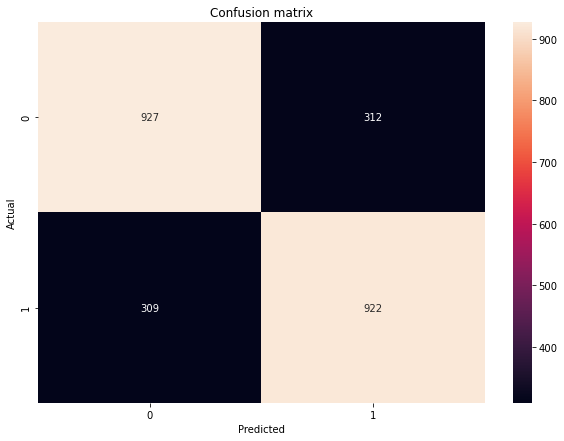

In [31]:

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,7))
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
_ = ax.set_title('Confusion matrix')

### Is there any meaningful diferrence between false negatives and false positives?

First, we build our dataframe and create a column called *Equal*, and the apply some pandas conditional to know which predictions were wrong or right.

In [32]:
Falses_dataset = pd.DataFrame({'validation':y_test,'predicted':predictions})
Falses_dataset = pd.concat([Falses_dataset,X_test], axis=1)
Falses_dataset.loc[Falses_dataset['validation'] == Falses_dataset['predicted'], "Equal"] = 'Equal'
Falses_dataset.loc[Falses_dataset['validation'] != Falses_dataset['predicted'], "Equal"] = 'Wrong'

Secondly, drop every prediction labeled as *Equal*

In [33]:
Falses_dataset.drop(Falses_dataset[Falses_dataset.Equal != 'Wrong'].index, inplace=True)
Falses_dataset.head()

,validation,predicted,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,Equal
6061,0,1,18,2,1,7,8,7,0,0,...,16843,7.0,17971,190,53,-1157,173,19.0,1684.3,Wrong
988,0,1,46,4,1,4,0,3,1,0,...,13691,6.8,17746,218,69,-2655,-1326,21.8,1369.1,Wrong
7324,0,1,13,0,1,8,4,10,1,0,...,14821,6.8,17046,196,44,-3117,-1580,19.6,1482.1,Wrong
2985,1,0,15,5,0,8,7,8,1,0,...,16923,6.8,17733,238,48,460,1189,23.8,1692.3,Wrong
5676,1,0,16,2,0,7,5,6,1,1,...,16914,7.0,18973,228,56,334,1403,22.8,1691.4,Wrong


Lastly, split the dataset into **false positives** and **false negatives**

In [34]:
Falses_dataset.loc[(Falses_dataset.validation == 0) & (Falses_dataset.predicted == 1), 'kind'] = 'FALSE POSITIVE'
Falses_dataset.loc[(Falses_dataset.validation == 1) & (Falses_dataset.predicted == 0), 'kind'] = 'FALSE NEGATIVE'
Falses_dataset.head()
mask_fn = (Falses_dataset['kind'] == 'FALSE NEGATIVE')
mask_fp = (Falses_dataset['kind'] == 'FALSE POSITIVE')

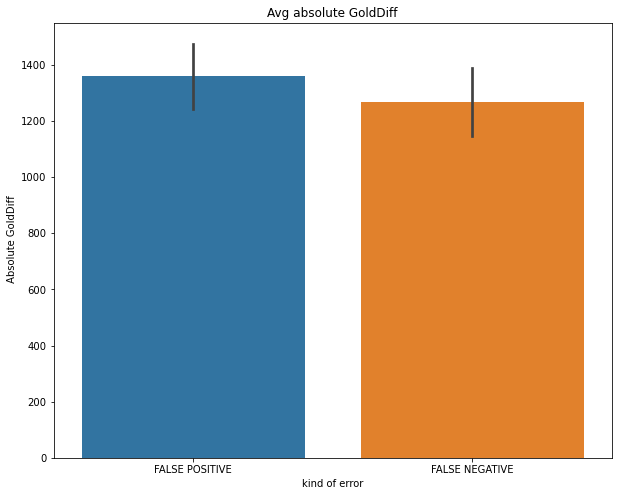

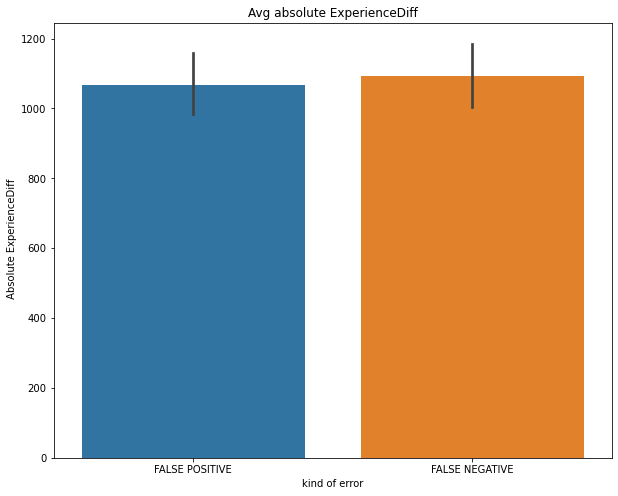

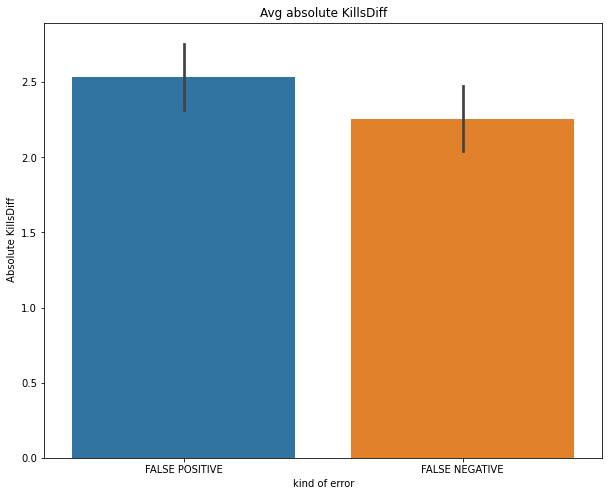

In [35]:
Falses_dataset['redKillsDiff'] = Falses_dataset['redKills'] - Falses_dataset['blueKills']
selected_columns = ['redGoldDiff', 'redExperienceDiff', 'redKillsDiff']
for column in selected_columns:
    col_str = column.replace('red', '')   
    Falses_dataset[column] = Falses_dataset[column].map(abs)
    plt.figure(figsize=(10,8))
    ax = sns.barplot(x = 'kind', y =column, data=Falses_dataset)
    ax.set_ylabel(f' Absolute {col_str}')
    _ = ax.set_title(f'Avg absolute {col_str}')
    ax.set_xlabel('kind of error')
    plt.subplot(ax)

Overall, False positives were caused mainly by a high gold difference, which ,as we'll confirm on the features importance graph, is in fact very important.

That could possibly be explained by the fact that early kills grant you gold, but that has to be capitalized into pressure to grant elite monsters, dragons and map pressure. If not, that means your early game *goldDiff* is not that relevant to the outcome of a match(*gold per min* usually increases in mid/late game).

No meaningful difference was seen on the *ExperienceDiff* graph.

### Now, a final look at the most important variables to our dataset

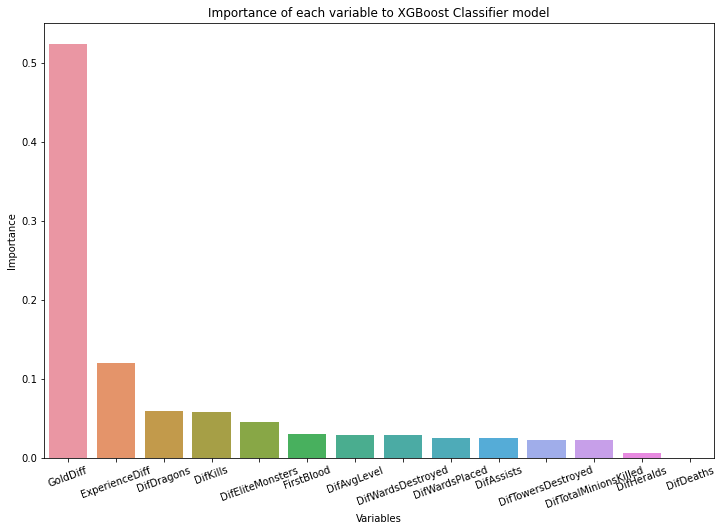

In [36]:
importance_df = pd.DataFrame({'Variables':dataset_2[0].columns,
              'Importance':XGBoost.feature_importances_}).sort_values('Importance', ascending=False)
plt.figure(figsize=(12,8))
plt.xticks(rotation=20)
plt.title('Importance of each variable to XGBoost Classifier model')
_ = sns.barplot(x='Variables', y='Importance',data=importance_df )

### Considerations

Although our dataset is not small, it is to be considered that most variables influence each other, such as:

*   Acquiring experience usually means earning gold.
*   Killing dragons also give you experience and gold.
*   The Average level is also influenced by experience(which influences gold).
*   Killing minions also increase the gold and experience earned(giving you more chances of conquering the dragon or other objectives).

So, as we can see, this is a tricky dataset to isolate casualties, which reduces drastically our model's accuracy.

The composition of teams and choice of champions really affect the duration of a match(Games with champions that are stronger at late game tend to last longer, meaning our dataset represents a smaller percentage of that specific match). Our dataset doesn't specify that, which would, in my belief, increase our model's performance.<br><br>
### Why did the first dataset(no feature engineering) performed better on most models?
<br>
Another thing is that comparative variables(such as the subtractions we made at the feature engineering section) don't always tell you how skilled a team is compared to the other. For example:

*    Match 1: at 10 minutes, team blue has 320 minions killed, and team red has 220.

*    Match 2: at 10 minutes, team red has 200 minions killed, and team red has 100.

in our dataset, both matches would have the same comparative value(100). However, the absolute values can also show how players are perfoming, or even the pace of the match(which is some hidden information about how well the composition does at early/late game). The duration of the match would also be a valuable information to have, giving us a better notion of how confident our model is on it's inference(the longer the match, the less confident it is).



## What valuable information can League of legends players extract from this analysis?
<br>

---

### Gold is what matters.

As seen on the feature importance graph, gold difference is by far the most important variable for our model. The fact that Exp difference is the second most important, probably means that farming is one of the most efficient ways to earn gold(also, it gives you more experience at a lower risk). That probably means you should be paying more attention to farming and lane phase than getting kills.

---

### Don't forget elite monsters.

On the 3rd and 5th position, we have elite monsters. So don't underestimate them, those buffs really can change the outcome of a match.

---
### Blocking vision is just as valuable as setting vision.

A surprising fact is that destroying wards is just as important as placing it. Leaving the enemy team blind is just as important as giving your team vision.

---

### Assists matter.

That doesn't mean that an assist by itself is that relevant to *gold difference*, but the meaning behind it: **play with your team**. Teams that are united usually get more kills, map pressure and objectives.

---

### Sacrificing yourself for an elite monster is not always worth it.

Elite monsters are important and can give you huge map pressure, but if that means having your entire team killed for it, maybe it's not that worth it. **Play smart**.

---

### Early game matters more than you think.

A model with data only from the 10 minutes of a match can predict it's outcome with a 75% accuracy, what does it tell you? The pace and attitude that you set at the beginning, most times, can be the difference between a victory or defeat.

## **Final considerations**

Considering all the lack of information, I think our model performed great, as it correctly guessed the outcome of ~75% matches only looking at a reduced amount of early game data.<br>

I'll try to find more complete data, so that the study can be remade in a near future.